We start by constructing a matrix with some low-rank structure plus noise that represents the evolution of a noisy dynamic system over time.

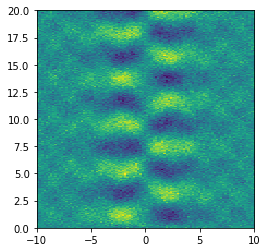

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, diag, exp, real, sin, cosh, tanh
from scipy.linalg import svd, svdvals

# define time and space domains
x = np.linspace(-10, 10, 100)
t = np.linspace(0, 20, 200)
Xm,Tm = np.meshgrid(x, t)

# create data
D = 5 * (1/cosh(Xm/2)) * tanh(Xm/2) * exp((1.5j)*Tm) # primary mode
D += 0.5 * sin(2 * Xm) * exp(2j * Tm)                # secondary mode
D += 0.5 * np.random.randn(*Xm.shape)                # noise

# plot image
plt.imshow(D.real,extent=[-10, 10, 0, 20])
plt.savefig('svhtimg1.eps',dpi=300,bbox_inches='tight')

The image clearly exhibits the two modes, spatial and temporal, and the added Gaussian noise with $\sigma = 0.5.$ We expect then to find two singular values that are large and well-separated from the rest of the singular spectrum. The rank should thus be $r=2.$

To see this, we compute the optimal SVHT, $\tau_* ,$ and use it to truncate the data matrix. We will assume that the noise variance is unknown, and use the approximation formula to obtain $\omega(\beta).$ Then, multiplying by the median of the computed singular values, we can compute an estimation of  $\tau_* $   

In [4]:
def omega_approx(beta):
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

# compute SVD and find optimal tau
U,sv,Vh = svd(D, False)
beta = min(D.shape) / max(D.shape)
tau = np.median(sv) * omega_approx(beta)

Print and plot the singular values and the cutoff threshold.

[181.97660307  49.36690931]


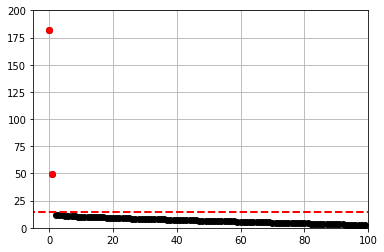

In [14]:
# plot singular values
r = np.max(np.where(sv > tau)) # Keep modes w/ sig > cutoff 
print(sv[:(r+1)])
N = D.shape[0]
plt.plot(sv,'o', color='k', LineWidth=2)
plt.plot((sv[:(r+1)]),'o', color='r', LineWidth=2)
plt.plot(np.array([-10, N+20]),np.array([tau, tau]),'--', color='r', LineWidth=2)
plt.xlim((-5,100))
plt.ylim((0,200))
plt.grid()
#plt.show()
plt.savefig('svhtimg2.eps',dpi=300,bbox_inches='tight')

We clearly observe the clean separation of the true modes from the noisy spectrum, where the dashed red line represents $\tau_*.$ We can now extract the de-noised data matrix.

[181.97660307  49.36690931   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         

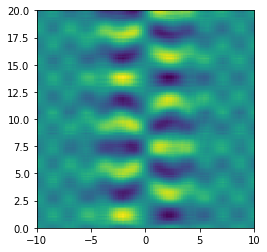

In [13]:
# reconstruct data (de-noised)
sv2 = sv.copy()
sv2[sv < tau] = 0
print(sv2)
D2 = dot(dot(U, diag(sv2)), Vh)
# plot image
plt.imshow(D2.real,extent=[-10, 10, 0, 20])
plt.savefig('svhtimg3.eps',dpi=300,bbox_inches='tight')

The Guassian noise has effectively been suppressed and we have a very low-rank represeentation, since there are only two non-zero entries in the diagonal matrix `sv`.

In [ ]:
def lambda_star(beta):
    """Return lambda star for given beta. Equation (11) from Gavish 2014."""
    return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

# find tau star
tau = lambda_star(beta) * np.sqrt(max(D.shape)) * 0.5


In [ ]:
def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

# find tau star hat when sigma is unknown
tau = svht(D, sv=sv)

# find tau star when sigma is known
tau = svht(D, sigma=0.5)

In [ ]:
# create matrix of random data
D = np.random.randn(100, 100)

# do SVD and find tau stars
U,sv,Vh = svd(D, False)
tau1 = svht(D, sv=sv) # sigma unknown
tau2 = svht(D, sigma=1) # sigma known

In [ ]:
# create data with a single mode traveling both spatially and in time
D = exp(-np.power((Xm-(Tm/2)+5)/2, 2))
D += 0.1 * np.random.randn(*Xm.shape) # noise
# plot image
plt.imshow(D,extent=[0, 100, 0, 100])

In [ ]:
# do SVD and find tau stars
U,sv,Vh = svd(D, False)
tau1 = svht(D, sv=sv) # sigma unknown
tau2 = svht(D, sigma=0.1) # sigma known

In [ ]:
# reconstruct data (de-noised)
sv2 = sv.copy()
sv2[sv < tau1] = 0
D2 = dot(dot(U, diag(sv2)), Vh)
# plot image
plt.imshow(D2,extent=[0, 100, 0, 100])